In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

get_ipython().run_line_magic('matplotlib', 'inline')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import models




In [2]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import InputXGradient
from captum.attr._core.guided_backprop_deconvnet import GuidedBackprop
from captum.attr._core.guided_grad_cam import GuidedGradCam
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import DeepLiftShap
from captum.attr import visualization as viz

In [3]:
#load data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# reference image
REFERENCE = 0 # select the images with labels = REFERENCE as references


transform = transforms.Compose(
     [transforms.ToTensor(),
#      transforms.Normalize((0.5,), (0.5,))
    ])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3000,
                                          shuffle=False, num_workers=2)

train_labels = trainset.train_labels.numpy()

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=3000,
                                         shuffle=False, num_workers=2)

classes = ['0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9']

test_labels = testset.test_labels.numpy()

/data/xiaoxiaol/anaconda3/envs/distdeepshap/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/data/xiaoxiaol/anaconda3/envs/distdeepshap/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [5]:
# In this cell, we train a model or load a pretrained model

USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('models/mnist_mlp.pt'))
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(50):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()*inputs.size(0)
        train_loss = running_loss/len(trainloader.dataset)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch + 1,
            train_loss
        ))

    print('Finished Training')
    torch.save(net.state_dict(), 'models/mnist_mlp.pt')


Using existing trained model


In [6]:
# In the cell below we load some images from the test dataset and perform predictions.

def imshow(img, transpose = True):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #npimg = npimg.reshape(-1,28,28)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

In [7]:
net.eval()

images = images.to(device)
outputs = net(images)

_, predicted = torch.max(outputs, 1)

In [8]:
# Let's choose a test image at index `ind` and apply some of our attribution algorithms on it.

# load a digit 8
ind = 61

input = images[ind].unsqueeze(0)
input.requires_grad = True


In [9]:
# A generic function that will be used for calling `attribute` on attribution algorithm defined in input.

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=predicted[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions     

In [10]:
# Define a few baseline methods
# Computes gradients with respect to class `ind` and transposes them for visualization purposes.

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item(), abs=False)
grads = np.transpose(grads.squeeze(axis=0).cpu().detach().numpy(), (1, 2, 0))




# Guided Propogate
gbp = GuidedBackprop(net)
attr_gbp = attribute_image_features(gbp, input)
attr_gbp = np.transpose(attr_gbp.squeeze(axis=0).cpu().detach().numpy(), (1, 2, 0))



input = input.cpu()
net = net.to('cpu')



# DeepLift
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))



# DeepLiftShap
ds = DeepLiftShap(net)
attr_ds = attribute_image_features(ds, input, baselines=trainset.data[np.where(train_labels==REFERENCE)[0]].view(-1,1,28,28).float()/255)
attr_ds = np.transpose(attr_ds.squeeze(0).cpu().detach().numpy(), (1, 2, 0))


/data/xiaoxiaol/anaconda3/envs/distdeepshap/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
/data/xiaoxiaol/anaconda3/envs/distdeepshap/lib/python3.6/site-packages/captum/_utils/gradient.py:58: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if input.grad is not None:
/data/xiaoxiaol/anaconda3/envs/distdeepshap/lib/python3.6/site-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on

Original Image
Index: 61 Predicted: 8  Probability: 0.9590604305267334


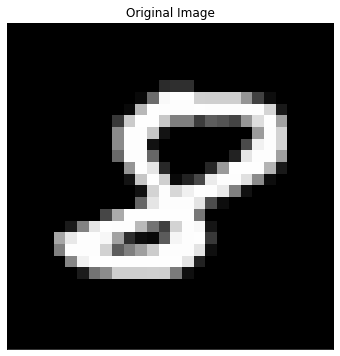

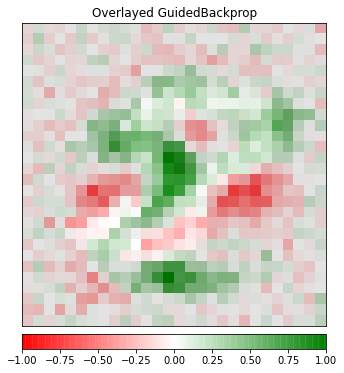

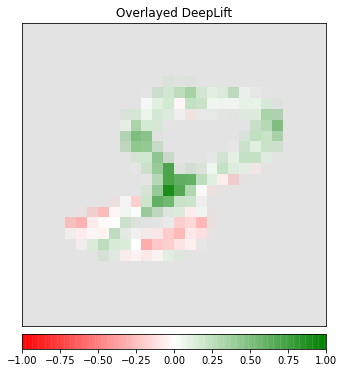

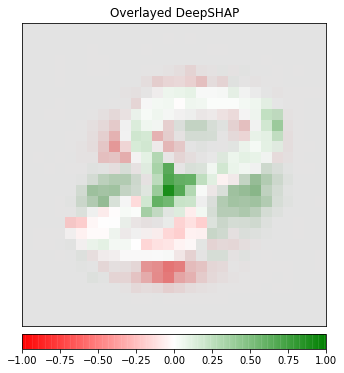

In [11]:
# Display original image and baseline methods
print('Original Image')
print('Index:', ind,'Predicted:', predicted[ind].item(),
      ' Probability:', torch.max(F.softmax(outputs, 1)[ind]).item())

#original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
original_image = np.transpose(images[ind].cpu().detach().numpy() , (1, 2, 0))

original_image = np.repeat(original_image,3,axis=-1)
grads = np.repeat(grads,3,axis=-1)
attr_gbp = np.repeat(attr_gbp,3,axis=-1)
attr_dl = np.repeat(attr_dl,3,axis=-1)
attr_ds = np.repeat(attr_ds,3,axis=-1)


fig,axis = viz.visualize_image_attr(None, original_image,
                          method="original_image", title="Original Image")
fig.savefig('figures/8_orig.png')
plt.close()

fig,axis = viz.visualize_image_attr(attr_gbp, original_image, method="blended_heat_map",sign="all",
                              show_colorbar=True, title="Overlayed GuidedBackprop",alpha_overlay=0.9)
fig.savefig('figures/8_GB.png')
plt.close()

fig,axis = viz.visualize_image_attr(attr_dl/attr_dl.max(), original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                              title="Overlayed DeepLift",alpha_overlay=0.9)
fig.savefig('figures/8_DL.png')
plt.close()
    
fig,axis = viz.visualize_image_attr(attr_ds, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepSHAP",alpha_overlay=0.9)
fig.savefig('figures/8_DS_{}.png'.format(REFERENCE))
plt.close()


/data/xiaoxiaol/anaconda3/envs/distdeepshap/lib/python3.6/site-packages/captum/_utils/gradient.py:58: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if input.grad is not None:
/data/xiaoxiaol/anaconda3/envs/distdeepshap/lib/python3.6/site-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/data/xiaoxiaol/anaconda3/envs/distdeepshap/lib/python3.6/site-packages/captum/_utils/gradient.py:87: UserWarning: The .g

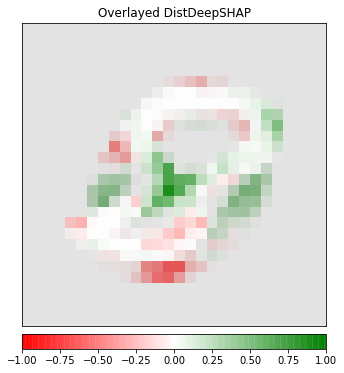

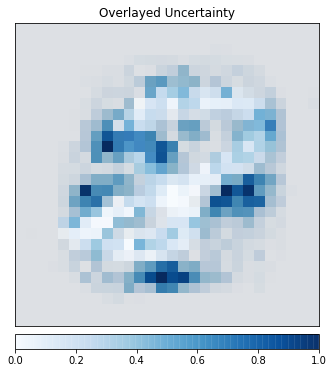

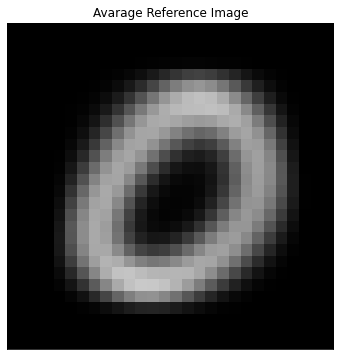

In [12]:
################  implementing our method #################
import scipy.stats

# Define function to calculate confidence interval
def median_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.median(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h



rept = 200 # Repeated sampling times. *Key Parameter*
ourds = DeepLift(net) # DistDeepSHAP is initilized with DeepLift

baselist = list(np.where(train_labels ==REFERENCE)[0]) #find the reference images ids pool

# Repeatedly sample single reference image and collect a list of importance scores
attr_ds_all = []
for r in range(rept):
    baseid = random.sample(baselist, 1)
    our_attr_ds = attribute_image_features(ourds, input,
                                           baselines=trainset.data[baseid[0]].view(-1, 1, 28, 28).float() / 255)
    our_attr_ds = np.transpose(our_attr_ds.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    attr_ds_all.append(our_attr_ds)

attr_ds_all = np.stack(attr_ds_all)
attr_ds_all = attr_ds_all.reshape(rept,-1)

# Calculate importance score and uncertainty 
uncertain = []
attr_dds = []
for i in range(attr_ds_all.shape[1]):
    m, low, high, h = median_confidence_interval(attr_ds_all[:,i], confidence=0.9)
    uncertain.append(2*h)
    attr_dds.append(m)

# For saliency and uncertainty maps visualization 
uncertain = np.array(uncertain)
uncertain = uncertain.reshape(28,28,1)
uncertain = np.repeat(uncertain,3,axis=-1)

attr_dds = np.array(attr_dds)
attr_dds = attr_dds.reshape(28,28,1)
attr_dds = np.repeat(attr_dds,3,axis=-1)

fig,axis = viz.visualize_image_attr(attr_dds, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DistDeepSHAP",alpha_overlay=0.9)
fig.savefig('figures/8_DDS_{}.png'.format(REFERENCE))
plt.close()

fig,axis = viz.visualize_image_attr(uncertain, original_image, method="blended_heat_map",sign="absolute_value",show_colorbar=True,
                          title="Overlayed Uncertainty",alpha_overlay=0.9)
fig.savefig('figures/8_uncertainty_{}.png'.format(REFERENCE))
plt.close()

# Averaged background image
background = trainset.data[np.where(train_labels==REFERENCE)[0]].view(-1,1,28,28).float()
background = background.numpy()
background = np.mean(background,axis=0)
background = np.transpose(background,(1, 2, 0))
background = np.repeat(background,3,axis=-1)/255
fig,axis = viz.visualize_image_attr(None, background,
                      method="original_image", title="Avarage Reference Image")
fig.savefig('figures/{}_background.png'.format(REFERENCE))
plt.close()


In [13]:
# !pip freeze > requirements.txt